In [22]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import os
import io
import base64
import tempfile
from IPython.display import HTML
from numpy import loadtxt

from controllers import DDeePC
from controller_utils import CartpoleDx, sample_initial_signal
from tqdm import tqdm
import torch
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from mpc import mpc
from mpc.mpc import GradMethods, QuadCost
import mpc.util as eutil


%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Collection


In [23]:
Tini = 4
m = 1
p = 4
Tf = 20
T = (m+1)*(Tini + Tf + p) + 14
n_batch = 32
device = 'cuda' if torch.cuda.is_available() else 'mps'
print(device)
ud = loadtxt('../badcartpole_ud.csv', delimiter=',')
yd = loadtxt('../badcartpole_yd.csv', delimiter=',')
yd = yd.reshape(T*p,)
noise = np.diag(np.kron(np.ones(T), np.array([0.01, 0.01, 0.005, 0.01]))) @ np.random.randn(*yd.shape)
yd = yd + noise
dx = CartpoleDx().to(device)
def uniform(shape, low, high):
    r = high-low
    return torch.rand(shape)*r+low

mps


In [24]:
u_constraints = np.ones(Tf)*dx.upper
y_constraints = np.kron(np.ones(Tf), np.array([1, 1, 0.1, 1]))
r = torch.ones(m)*0.1
q = torch.ones(p)*10
lam_g1 = torch.Tensor([20])
lam_g2 = torch.Tensor([20])

controller = DDeePC(
    ud=ud, yd=yd, u_constraints=u_constraints, y_constraints=y_constraints,
    Tini=Tini, T=T, N=Tf, m=m, p=p, n_batch=n_batch, device=device,
    linear=False, stochastic=True, q=q, r=r
).to(device)

In [25]:
for param in controller.parameters():
    print(param)

Parameter containing:
tensor([9.9973], device='mps:0', requires_grad=True)
Parameter containing:
tensor([0.9911], device='mps:0', requires_grad=True)
Parameter containing:
tensor([0.9887], device='mps:0', requires_grad=True)


In [26]:
episodes = 100
ref = torch.zeros(size=(n_batch,p))
perfect = torch.kron(torch.ones(episodes+Tini), ref).to(device)
ref = torch.kron(torch.ones(Tf), ref).to(device)
n_row = np.sqrt(n_batch)
n_col = n_row
opt = torch.optim.Rprop(controller.parameters(), lr=0.01, step_sizes=(1e-3,1e2))
criterion = torch.nn.HuberLoss()

epochs = 100
pbar = tqdm(range(epochs))
cum_loss = []
done = False

for j in pbar:

    # uini, yini = sample_initial_signal(Tini=Tini, m=m, p=p, batch=n_batch, ud=ud, yd=yd)
    uini = torch.zeros(size=(n_batch, Tini*m)).to(device)
    th = uniform((n_batch), -0.01, 0.01)
    x = uniform((n_batch), -0.001, 0.001)
    thdot = uniform((n_batch), -0.001, 0.001)
    xdot = uniform((n_batch), -0.001, 0.001)
    yini = torch.stack((x, xdot, th, thdot), dim=1).repeat(1,Tini).to(device)
    traj = yini
    count = 0

    t_dir = tempfile.mkdtemp()

    for i in range(episodes):
        count = i
        yini = traj[:,-p*Tini:]
        
        # TODO: Give different noise vectors to each yini instead of just repeating the same one
        noise = torch.diag(torch.kron(torch.ones(Tini), torch.Tensor([0.01, 0.01, 0.005, 0.01])))@torch.randn(p*Tini,)
        noise = noise.repeat(n_batch, 1).to(device)

        u_pred, _ = controller(ref=ref, y_ini=yini+noise, u_ini=uini)
        input = u_pred[:,:m]
        y = dx(yini[:,-p:], input)

        traj = torch.cat((traj, y), axis=1)
        # fig, axs = plt.subplots(n_row, n_col, figsize=(3*n_col,3*n_row), gridspec_kw = {'wspace':0, 'hspace':0})
        # axs = axs.reshape(-1)
        # for i in range(n_batch):
        #     dx.get_frame(x[i], ax=axs)
        #     axs.get_xaxis().set_visible(True)
        #     axs.get_yaxis().set_visible(True)
        # fig.tight_layout()
        # fig.savefig(os.path.join(t_dir, 'frame_{:03d}.png'.format(i)))
        # plt.close(fig)
        
        if torch.any(torch.abs(yini[:,-2]) >= 0.2) or torch.any(torch.abs(yini[:,1]) >= 0.25):
            break

        if i >= episodes -1 : 
            done = True

    if count < episodes-1:
        remainder = torch.ones(n_batch, (episodes-count-1)*p).to(device)*10
        traj = torch.cat((traj, remainder), axis=1)

    loss = criterion(target=perfect, input=traj)
    cum_loss.append(loss.item())
    opt.zero_grad()
    loss.backward()
    opt.step()

    pbar.set_description(f'l={loss.item():.3f}, ly={controller.lam_y.data.item():.3f},\
 lg1={controller.lam_g1.data.item():.3f}, lg2={controller.lam_g2.data.item():.3f}, ep={count}\
 q={controller.q.data}, r={controller.r.data.item():.3f}')

l=5.116, ly=100.775, lg1=0.040, lg2=0.398, ep=43 q=tensor([10., 10., 10., 10.], device='mps:0'), r=0.100:  98%|█████████▊| 98/100 [1:59:07<02:27, 73.73s/it]  

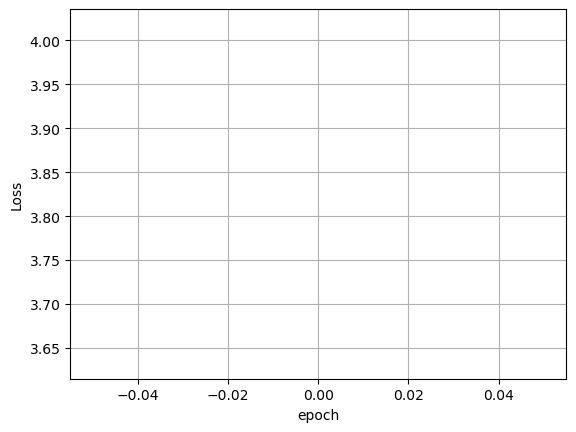

In [ ]:
plt.plot(range(len(cum_loss)), cum_loss)
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.grid('on')
plt.show()

In [ ]:
for param in controller.parameters():
    print(param)

Parameter containing:
tensor([0.8974], requires_grad=True)
Parameter containing:
tensor([0.9907], requires_grad=True)
Parameter containing:
tensor([0.9896], requires_grad=True)


In [ ]:
vid_fname = 'cartpole_initial.mp4'
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}/%03d.png -vcodec libx264 -crf 25 -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" -pix_fmt yuv420p {}'.format(
    t_dir, vid_fname
)
os.system(cmd)
# print('Saving video to: {}'.format(vid_fname))

video = io.open(vid_fname, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/Users/runner/miniforge3/conda-bld/ffmpeg_1674566267822/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1674566267822/_build_env/bin/x86_64-apple-darwin13.4.0-clang --enable-neon --enable-gnutls --enable-libmp3lame --enable-libvpx --enable-pthreads --enable-gpl --enable-libx264 --enable

Saving video to: cartpole_initial.mp4


frame=  100 fps=0.0 q=-1.0 Lsize=      18kB time=00:00:06.06 bitrate=  25.0kbits/s speed=31.3x    
video:16kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 11.966369%
[libx264 @ 0x12ce2b4d0] frame I:1     Avg QP:22.38  size:   347
[libx264 @ 0x12ce2b4d0] frame P:39    Avg QP:25.99  size:   193
[libx264 @ 0x12ce2b4d0] frame B:60    Avg QP:30.92  size:   138
[libx264 @ 0x12ce2b4d0] consecutive B-frames: 10.0% 26.0% 12.0% 52.0%
[libx264 @ 0x12ce2b4d0] mb I  I16..4: 16.6% 81.9%  1.5%
[libx264 @ 0x12ce2b4d0] mb P  I16..4:  0.0%  0.7%  0.6%  P16..4:  0.2%  0.1%  0.0%  0.0%  0.0%    skip:98.4%
[libx264 @ 0x12ce2b4d0] mb B  I16..4:  0.0%  0.0%  0.2%  B16..8:  1.1%  0.2%  0.0%  direct: 0.0%  skip:98.4%  L0:53.2% L1:36.0% BI:10.7%
[libx264 @ 0x12ce2b4d0] 8x8 transform intra:65.6% inter:15.9%
[libx264 @ 0x12ce2b4d0] coded y,uvDC,uvAC intra: 13.4% 0.0% 0.0% inter: 0.1% 0.0% 0.0%
[libx264 @ 0x12ce2b4d0] i16 v,h,dc,p: 54% 45%  1%  0%
[libx264 @ 0x12ce2b4d0] i8 v,h,dc,d